In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

from keras import Sequential
from keras.layers import Dense, Dropout, LSTM, Masking
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
#Import data and give column names

train = pd.read_csv('../../data/feature_selected_train_FD001.csv', sep=',', header=0, engine='python')
test = pd.read_csv('../../data/feature_selected_test_FD001.csv', sep=',', header=0, engine='python')
y_test = pd.read_csv('../../data/RUL_FD001.csv', sep=',', header=0,  engine='python')

index_names = train.columns[[0, 1]]
setting_names = train.columns[[2]]
sensor_names = train.drop(index_names.union(setting_names), axis = 1).columns # Find something better than union!!
scale_columns = sensor_names
keep_columns = scale_columns.union(index_names[[1]])

In [7]:
def scale_data(df, columns):
    sc = MinMaxScaler()
    scaled_data = df.copy()
    scaled_data[columns] = pd.DataFrame(sc.fit_transform(scaled_data[columns]))
    return scaled_data

In [8]:
def scale_data_quantile(df, columns):
    sc = qt = QuantileTransformer(n_quantiles=10, random_state=0)
    scaled_data = df.copy()
    scaled_data[columns] = pd.DataFrame(qt.fit_transform(scaled_data[columns]))
    return scaled_data

In [9]:
def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_no")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_no', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [10]:
def train_val_group_split(x_data, y_data, gss, groups, print_groups=True):
    for idx_train, idx_val in gss.split(x_data, y_data, groups=groups):
        if print_groups:
            print('train_split_engines', x_data.iloc[idx_train]['unit_no'].unique())
            print('validate_split_engines', x_data.iloc[idx_val]['unit_no'].unique(), '\n')

        x_train = x_data.iloc[idx_train].copy()
        y_train = y_data.iloc[idx_train].copy()
        x_val = x_data.iloc[idx_val].copy()
        y_val = y_data.iloc[idx_val].copy()
    return x_train, y_train, x_val, y_val

In [11]:
def generator_training(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]
        
def generator_training_wrapper(df, sequence_length, columns, unit_nos=np.array([])):
    if unit_nos.size <= 0:
        unit_nos = df['unit_no'].unique()
    #Runs the generator_training_data function for all units
    seperate_unit_gen = (list(generator_training(df[df['unit_no']==unit_no], sequence_length, columns))
               for unit_no in unit_nos)
    #Combine the subsets into a new set of sequences    
    combined_units_gen = np.concatenate(list(seperate_unit_gen)).astype(np.float32)
    return combined_units_gen

In [12]:
def generator_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # padded sequences
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values
    else:
        data_matrix = df[columns].values
        
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

def generator_test_wrapper(df, sequence_length, columns, unit_nos=np.array([])):
    if unit_nos.size <= 0:
        unit_nos = df['unit_no'].unique()
    test_gen = (list(generator_test_data(df[df['unit_no']==unit_no], sequence_length, keep_columns, -99.))
           for unit_no in unit_nos)   
    combined_units_gen = np.concatenate(list(test_gen)).astype(np.float32)
    return combined_units_gen

In [13]:
def generator_labels(df, sequence_length, label_column):
    data = df[label_column].values
    num_elements = data.shape[0]
    #-1 makes sure that the label returned is the last row of the sequence, not the beginning of the next sequence
    return data[sequence_length-1:num_elements, :]

def generator_label_wrapper(df, sequence_length, label, unit_nos=np.array([])):
    if unit_nos.size <= 0:
        unit_nos = df['unit_no'].unique()
        
    seperate_unit_gen = (generator_labels(df[df['unit_no']==unit_no], sequence_length, label) 
                for unit_no in unit_nos)
    comined_units_gen = np.concatenate(list(seperate_unit_gen)).astype(np.float32)
    return comined_units_gen

In [14]:
def create_model(x_train, y_train, x_val, y_val, epochs, model_name):
    model = Sequential()
    model.add(Masking(mask_value = -99., input_shape=(None, x_train.shape[2])))
    model.add(LSTM(256, activation='sigmoid', return_sequences = True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    save_best_model = ModelCheckpoint('{}.hdf5'.format(model_name), save_best_only=True, monitor='val_loss', mode='min')
    
    #model.load_weights('simple_lstm_weights.h5')
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=128,
                        callbacks = [save_best_model]
                       )
    return model, history

In [15]:
def load_models(x_train, y_train, x_val, y_val, epochs, model_name):
    model = load_model('{}.hdf5'.format(model_name))
    save_best_model = ModelCheckpoint('{}.hdf5'.format(model_name), save_best_only=True, monitor='val_loss', mode='min')
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=128,
                        callbacks = [save_best_model]
                       )
    return model, history

In [16]:
def plot_loss(history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='train')
    plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [17]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [18]:
def plot_predictions(y_true, y_predicted):
    plt.figure(figsize=(13,5))
    plt.plot(y_true, label='true')
    plt.plot(y_predicted, label='predicted')
    plt.xlabel('Predictions')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

In [19]:
def model_run(data, test_data, load, sequence_length, epochs, model_name):
    data = add_remaining_useful_life(data)
    data = scale_data(data, scale_columns)
    gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=1) 
    x_train, y_train, x_val, y_val = train_val_group_split(data.drop(['RUL'], axis = 1), data[['RUL', 'unit_no']], gss, data['unit_no'])
    
    generator_x_train = generator_training_wrapper(x_train, sequence_length, keep_columns)
    generator_x_val = generator_training_wrapper(x_val, sequence_length, keep_columns)
    
    generator_y_train = generator_label_wrapper(y_train, sequence_length, ['RUL'])
    generator_y_val = generator_label_wrapper(y_val, sequence_length, ['RUL'])
    
    
    if(load == True):
        model, history = load_models(generator_x_train, generator_y_train, generator_x_val, generator_y_val, epochs, model_name)
    else:
        model, history = create_model(generator_x_train, generator_y_train, generator_x_val, generator_y_val, epochs, model_name)
    
    plot_loss(history)
    
    test_data = scale_data(test_data, keep_columns)
    generator_x_test = generator_test_wrapper(test_data, sequence_length, keep_columns)
    
    y_predicted = model.predict(generator_x_train)
    evaluate(generator_y_train, y_predicted, 'train')
    plot_predictions(generator_y_train, y_predicted)
    
    y_predicted = model.predict(generator_x_val)
    evaluate(generator_y_val, y_predicted, 'val')
    plot_predictions(generator_y_val, y_predicted)
    
    y_predicted = model.predict(generator_x_test)
    evaluate(y_test, y_predicted, 'test')
    plot_predictions(y_test, y_predicted)

train_split_engines [  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  35  36  38  39  41  42  43
  44  46  47  48  49  50  51  54  55  56  58  59  60  61  62  63  64  65
  67  68  69  71  72  73  74  75  76  77  78  80  84  86  87  88  89  90
  91  92  95  96  97  98  99 100]
validate_split_engines [11 18 32 33 34 37 40 45 52 53 57 66 70 79 81 82 83 85 93 94] 

Train on 8743 samples, validate on 1988 samples
Epoch 1/2
8743/8743 [==============================] - 87s 10ms/step - loss: 94.9271 - val_loss: 79.9910
Epoch 2/2
8743/8743 [==============================] - 114s 13ms/step - loss: 109.3350 - val_loss: 82.8368


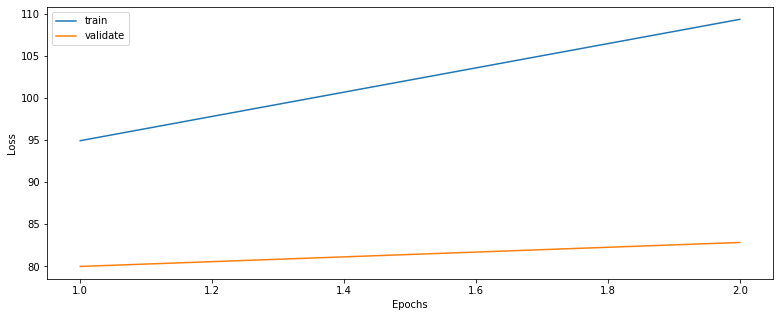

train set RMSE:8.843457221984863, R2:0.9669948675862314


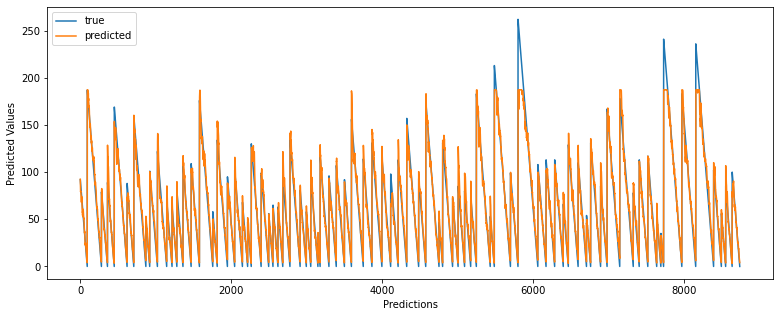

val set RMSE:9.101470947265625, R2:0.9476598528564406


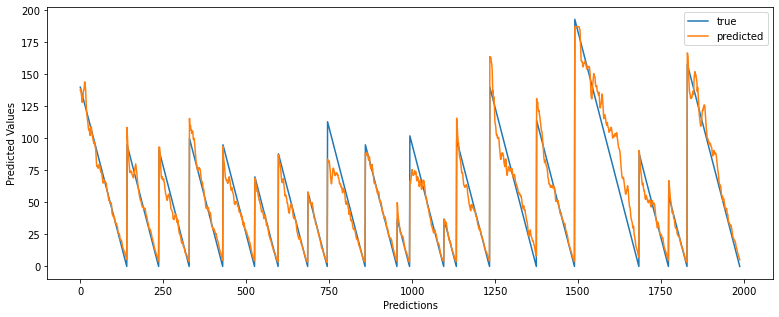

test set RMSE:33.94024275774218, R2:0.33293163626571975


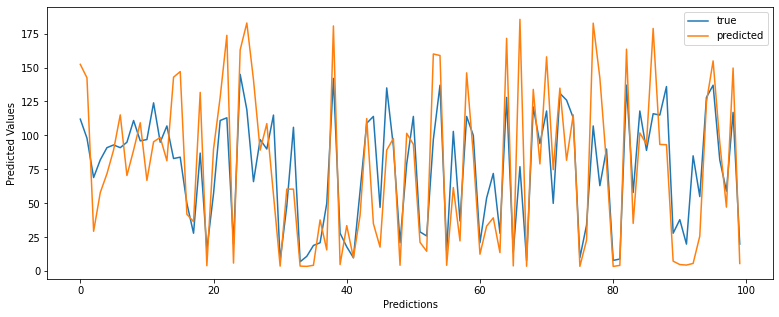

In [20]:
epochs = 2
sequence_length = 100
model_run(train, test, load = True, sequence_length = sequence_length, epochs = epochs, model_name = 'lstm_Azure')
#model_run(train, test, load = False, sequence_length = sequence_length, epochs = epochs, model_name = 'lstm_test')